In [1]:
!pip install -q -U keras-tuner

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers, Input
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.models import Sequential, Model
import keras_tuner as kt

import matplotlib.image as mpimg

from PIL import Image
import os
import glob


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

tf.__version__

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# Before using the data need to upload on to drive
# This file will be deleted at the end of the session
# Go to file on left hand side of the screen then upload file (Can upload the file to root easier access)
# File extracted will be saved in content
from zipfile import ZipFile
file_name = '/trafficsigns_dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


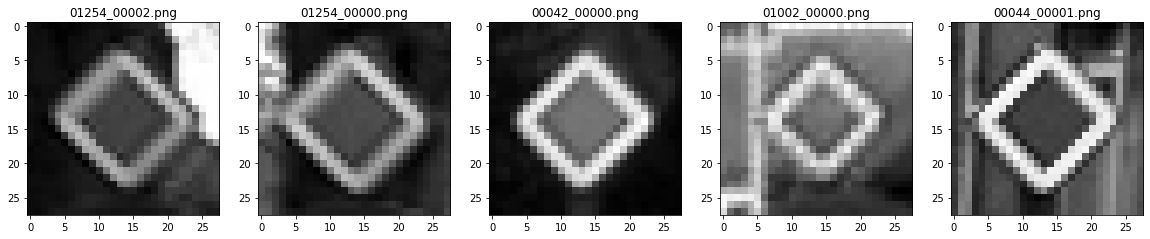

In [4]:
# This is just to test if image is loaded correctly


plt.figure(figsize=(20,20))
test_folder=r'/content/trafficsigns_dataset/diamond/rightofway'
for i in range(5):                                                    # Randomly loaded 5 images
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img, cmap = 'gray')

# **1. Data Preparation**
**Importing data into dataframe**

Data will be stored in a dataframe which has image path, shape and type as columns.

In [5]:
image_list = []

for filepath in glob.glob('./trafficsigns_dataset/*/*/*.png', recursive=True):
    sign_shape = filepath.split('/')[2]
    sign_type = filepath.split('/')[3]
    image_list.append((filepath, sign_shape, sign_type ))
    
    
# create a dataframe
data = pd.DataFrame(data= image_list, columns=["image_path", 'sign_shape','sign_type'])
# inspecting the dataframe
data.head()   

,image_path,sign_shape,sign_type
0,./trafficsigns_dataset/triangle/giveway/01204_...,triangle,giveway
1,./trafficsigns_dataset/triangle/giveway/00963_...,triangle,giveway
2,./trafficsigns_dataset/triangle/giveway/01513_...,triangle,giveway
3,./trafficsigns_dataset/triangle/giveway/01207_...,triangle,giveway
4,./trafficsigns_dataset/triangle/giveway/00982_...,triangle,giveway


In [6]:
# data shape
data.shape

(3699, 3)

In [7]:
print("numbers of shape:", len(data.sign_shape.unique()))
data.sign_shape.unique()

numbers of shape: 5


array(['triangle', 'diamond', 'round', 'hex', 'square'], dtype=object)

In [8]:
print("numbers of type:", len(data.sign_type.unique()))
data.sign_type.unique()

numbers of type: 16


array(['giveway', 'warning', 'rightofway', 'traveldirection', 'noentry',
       'speed', 'noparking', 'roundabout', 'bicycle', 'trafficdirective',
       'limitedtraffic', 'stop', 'parking', 'laneend', 'continue',
       'crossing'], dtype=object)

**Labels encoding**

Using label encoder from sklearn to transform label into integer.

In [9]:
labelEncoder = LabelEncoder()
data.sign_shape = labelEncoder.fit_transform(data.sign_shape)
data.sign_type = labelEncoder.fit_transform(data.sign_type)
# inspecting the changes
data.head()

,image_path,sign_shape,sign_type
0,./trafficsigns_dataset/triangle/giveway/01204_...,4,3
1,./trafficsigns_dataset/triangle/giveway/00963_...,4,3
2,./trafficsigns_dataset/triangle/giveway/01513_...,4,3
3,./trafficsigns_dataset/triangle/giveway/01207_...,4,3
4,./trafficsigns_dataset/triangle/giveway/00982_...,4,3


**Data Distribution**

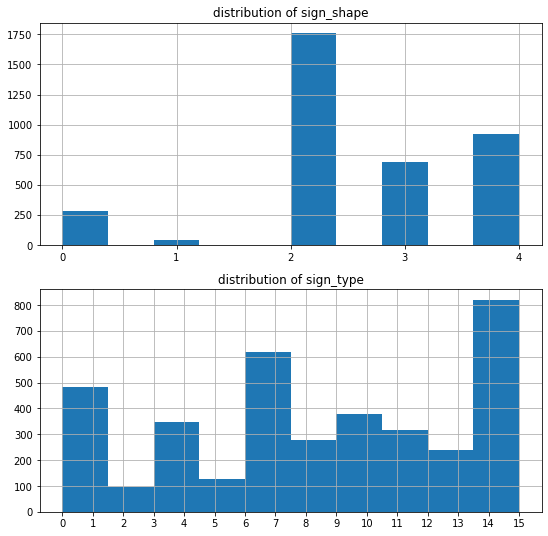

In [10]:
plt.figure(figsize=(9,9))
for i in range(1,3):
    plt.subplot(2,1,i)
    data.iloc[:, i].sort_values().astype(str).hist()
    txt = "distribution of " + data.columns[i]
    plt.title(txt)

**<u>Observation</u>:**

 * Data has multiple classes for shape and type of the traffic sign
 * Class imbalance problem in both shape and type data <br>
 * performance measure : F1, log_loss and average accuracy(micro-average)<br>

What is the realistic result for performance measure?

# **2. Model Development**
* Goal:
* Setup the experiment:
* Baseline Model:
* incremental changes:

## **2.1 Image Data Generator**

### **2.1.1 Function to generate data**

In [11]:
class dataGenerator:
  def __init__(self, data, target_column_name):
    self.data = data
    self.target_column_name = target_column_name
    # Splitting input data into train, validation set
    self.path_train, self.path_validation = self.split_train_validation()
    print(f"Train data {target_column_name} : {self.path_train.shape[0]}\nVal Data {target_column_name}: {self.path_validation.shape[0]}")
    # Convert the target column into string array
    self.convert_target_column_to_String(self.path_train, self.path_validation)
    # Generating actual data from filepath
    self.train, self.validation = self.__generating_data_from_dataframe__()
   

  def split_train_validation(self):
    """
    Function to split input data into train, validation set
    """
    return train_test_split(self.data, random_state = random.randint(0, 100), test_size=0.2)

  def convert_target_column_to_String(self, train, validation):
    """
    Function to convert the refering target_column_name into string array
    """
    train.loc[:,self.target_column_name] = train.loc[:,self.target_column_name].astype('str')
    validation.loc[:, self.target_column_name] = validation.loc[:,self.target_column_name].astype('str')
    
  def __generating_data_from_dataframe__(self):
    """
    Function to generate actual data from file path
    """
    train_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    val_datagen = ImageDataGenerator(rescale = 1./255, data_format = 'channels_last')
    batch_size = 32
    train = train_datagen.flow_from_dataframe(
        dataframe = self.path_train,
        directory = './',
        x_col = "image_path",
        y_col = self.target_column_name,
        target_size = (28, 28),
        batch_size = batch_size,
        class_mode = 'categorical')

    validation = val_datagen.flow_from_dataframe(
        dataframe = self.path_validation,
        directory = './',
        x_col = "image_path",
        y_col = self.target_column_name,
        target_size = (28, 28),
        batch_size = batch_size,
        class_mode = 'categorical')
    return train, validation


### **2.1.2 Shape Data**

Split data into train and validation set

In [12]:
dataShape = dataGenerator(data, "sign_shape")

Train data sign_shape : 2959
Val Data sign_shape: 740
Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


### **2.1.2 Type Data**

In [13]:
dataType = dataGenerator(data, "sign_type")

Train data sign_type : 2959
Val Data sign_type: 740
Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


## **2.2 Build Model**

In [14]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [24]:
def model_compiling_and_fit(model):
  model.compile(
              # Use sgd over adam as our dataset is not very large so we care more about generalized
              # adam would be better in case we need the data to be able to converge faster
              optimizer = 'sgd',
              # Use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])
  
  early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
  
  history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0, callbacks = [early_stopping_cb])

In [16]:
input_dimension = (28,28,3)
numbers_of_shape = len(data.sign_shape.unique())
numbers_of_sign = len(data.sign_type.unique())

### **2.2.1 Multilayer Perceptron Neural Network**

#### 2.2.1.1 Shape

#### A. Baseline Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dimension),
    tf.keras.layers.Dense(320, activation='sigmoid'),
    tf.keras.layers.Dense(5, 'softmax')
])

**Compile model**

In [ ]:
model.compile(optimizer = 'sgd',
              # use categorical_crossentropy instead of sparse as we use one hot label encoder
              loss = "categorical_crossentropy",     
              metrics = ['categorical_accuracy'])

**Train model**

In [ ]:
history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


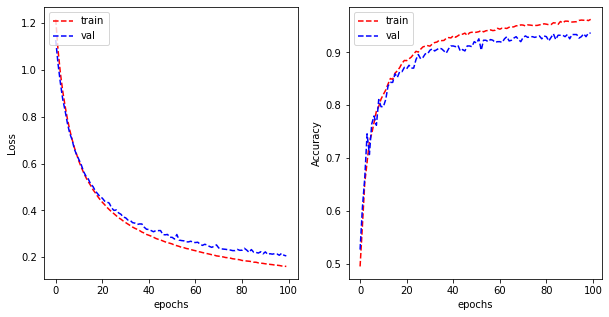

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

#### B. Hyperparameter Tuning Model

In [ ]:
def parameters( layer, units, activation, dropout, lr,  numbers_of_label,  momentum):
    model = keras.Sequential([tf.keras.layers.Flatten(input_shape = input_dimension)])
    # Tune the number of layers
    for i in range(layer):
        model.add(layers.Dense(units=units, activation = activation))
    # tune dropout  
    if dropout:
        model.add(layers.Dropout(rate = 0.3))
    # output layer
    model.add(layers.Dense(numbers_of_label, activation = 'softmax'))
    
    # loss function
    model.compile(optimizer=keras.optimizers.SGD(learning_rate = lr,  
                                                momentum = momentum, nesterov = True),
                                                loss = 'CategoricalCrossentropy',
                                                metrics = ['categorical_accuracy'])
    return model


def build_model(hp):
    # Declaring the number of layers to be tuned
    layer = hp.Int("num_layers", 1, 3)
    # Declaring the number of units per layer to be tuned
    units = hp.Int("units", min_value = 16, max_value = 512, step = 16)
    # Declaring the activaiton functionto be tuned
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
    dropout = hp.Boolean('dropout')
    # Declaring the learning rate range to be tuned
    lr = hp.Float('lr', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
    momentum = hp.Float('momentum', min_value = 0.1, max_value = 0.9, sampling = 'log' )
    model = parameters( layer = layer, units = units, activation = activation, dropout = dropout,
                    momentum = momentum, lr = lr, numbers_of_label = numbers_of_shape)    
    return model


build_model(kt.HyperParameters())

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective = "val_categorical_accuracy", 
    max_trials = 3,
    executions_per_trial = 2,
    overwrite = True,
    directory = "my_dir",
    project_name = "helloworld",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'elu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': None, 'sampling': 'log'}


In [ ]:
# create weight for imbalance class
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = data.sign_shape.unique(),
                                                 y = data.sign_shape.to_numpy())

# convert class_weights to dictionary
class_weight_dict = dict()
i = 0
for w in class_weights:
    class_weight_dict[i] = w
    i= i+1

In [ ]:
tuner.search(dataShape.train, epochs=100, validation_data=dataShape.validation,class_weight=class_weight_dict , callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")])

Trial 3 Complete [00h 07m 50s]
val_categorical_accuracy: 0.9277027249336243

Best val_categorical_accuracy So Far: 0.9662162065505981
Total elapsed time: 00h 25m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get best model and best hyper parameter
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
#best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 416)               978848    
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dense_2 (Dense)             (None, 416)               173472    
                                                                 
 dropout (Dropout)           (None, 416)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2085      
                                                                 
Total params: 1,327,877
Trainable params: 1,327,877
Non-

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2600), started 1:16:12 ago. (Use '!kill 2600' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
model = tuner.hypermodel.build(best_hp)
history = model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=100, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


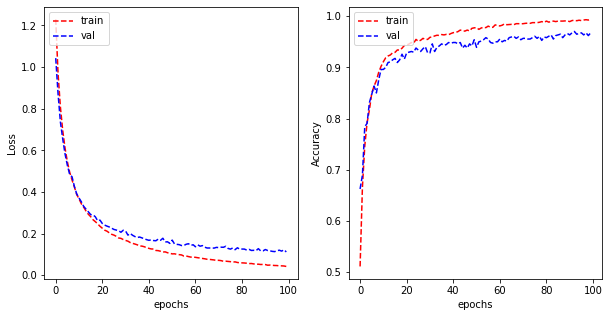

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

In [ ]:
# get the best epoch
val_acc_per_epoch = history.history['val_categorical_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 93


In [ ]:
# Retrain the model with the best epoch
finale_model = tuner.hypermodel.build(best_hp)

finale_model.fit_generator(dataShape.train, validation_data = dataShape.validation, epochs=best_epoch, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


#### 2.2.1.2 Type

### **2.2.2 Convolution Neural Network**

In this section, we will implement two popular CNN architectural namely VGG and LeNet as our baseline model. Depending on the result, we will configure the architecture so as to be able to figure out the best solution for this image classification problem.

#### A. VGG CNN Model

The VGG architecture that was used as the baseline model for this project is the modified architecture that was provided in the lecture (**link**). 

This modified architecture was chosen over the original VGG architecture as the original one contains many VGG - block (convolution + activation + pooling) and it is more suitable for larger image, however, our image is only of 28 * 28, which makes the modified version preferable. 

In [22]:
VGG_model = tf.keras.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(28, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(numbers_of_shape, activation = "softmax"),
    ])
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 28)        784       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 28)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        16192     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                  

In [ ]:
model_compiling_and_fit(VGG_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name = 'Accuracy')

https://keras.io/guides/keras_tuner/getting_started/

https://keras.io/keras_tuner/

https://keras.io/guides/keras_tuner/visualize_tuning/

https://www.tensorflow.org/tutorials/keras/keras_tuner

Hoang check links for documentation on tuner